<a href="https://colab.research.google.com/github/chuan1215/DLI_GroupAG/blob/main/Copy_of_LauYongFeng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pandas as pd

data_path = "/content/drive/MyDrive/Colab Notebooks/dataset_phishing.csv"
df = pd.read_csv(data_path)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (11430, 89)


,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [4]:
# Drop rows with missing values
df.dropna(inplace=True)
print("After dropping NA:", df.shape)

# Check if there are any categorical values that need encoding
print("Data types:\n", df.dtypes)

# Identify the label column (based on your output, it's likely 'status')
if 'class' in df.columns:
    df.rename(columns={'class': 'label'}, inplace=True)
elif 'status' in df.columns:
    df.rename(columns={'status': 'label'}, inplace=True)
else:
    raise KeyError("No target label column found. Please ensure the dataset has a 'class' or 'status' column.")

# Drop non-numeric and non-informative columns like 'url'
df.drop(columns=['url'], inplace=True, errors='ignore')

# Convert label column to binary (e.g., 'phishing' = 1, 'legitimate' = 0)
df['label'] = df['label'].map({'phishing': 1, 'legitimate': 0})

After dropping NA: (11430, 89)
Data types:
 url                object
length_url          int64
length_hostname     int64
ip                  int64
nb_dots             int64
                    ...  
web_traffic         int64
dns_record          int64
google_index        int64
page_rank           int64
status             object
Length: 89, dtype: object


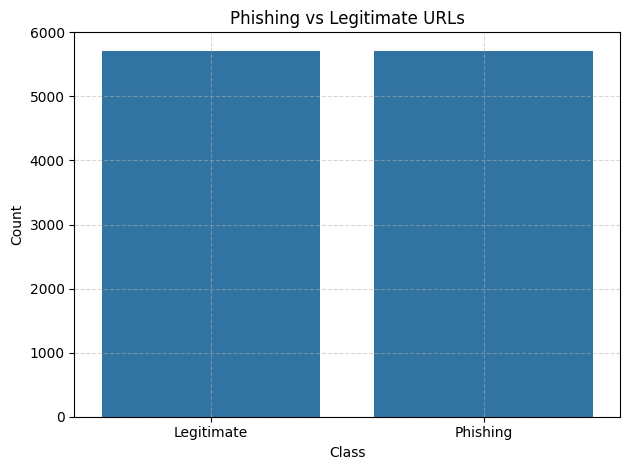

In [5]:
sns.countplot(data=df, x='label')
plt.title('Phishing vs Legitimate URLs')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Separate features and target
X = df.drop(columns=['label'])
y = df['label']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

[INFO] Class weight setting: None
Fitting 2 folds for each of 3 candidates, totalling 6 fits

[RESULT] Best parameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': None, 'bootstrap': True}
[RESULT] Best CV score: 0.960082022774343

Accuracy: 0.968503937007874

Classification Report:
               precision    recall  f1-score   support

           0     0.9649    0.9732    0.9690      1157
           1     0.9723    0.9637    0.9680      1129

    accuracy                         0.9685      2286
   macro avg     0.9686    0.9684    0.9685      2286
weighted avg     0.9685    0.9685    0.9685      2286



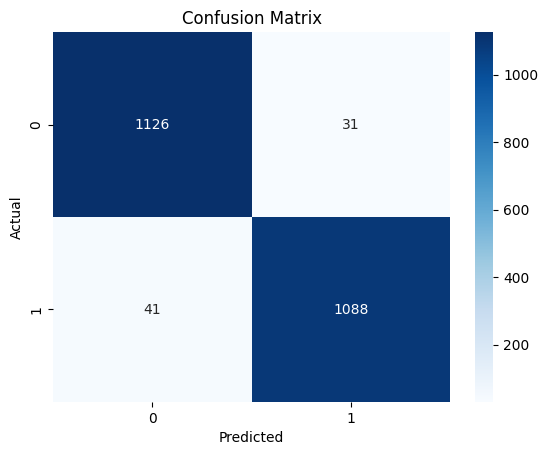

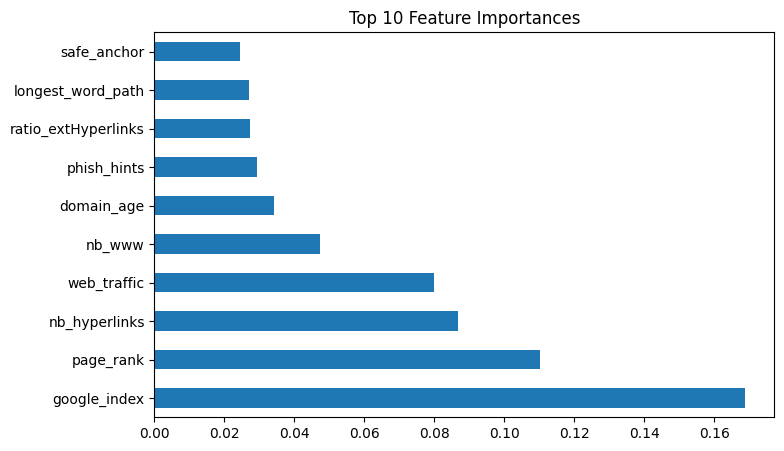

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

# Check class imbalance
unique_classes, class_counts = np.unique(y_train, return_counts=True)
class_weights = 'balanced' if max(class_counts) / min(class_counts) > 1.5 else None
print("[INFO] Class weight setting:", class_weights)

# Very small parameter ranges for speed
param_dist = {
    'n_estimators': [100, 150, 200],  # fewer trees
    'max_depth': [10, None],          # smaller search space
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'class_weight': [class_weights] if class_weights else [None]
}

# Randomized Search (fast settings)
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=3,         # only 3 combinations
    cv=2,             # 2-fold CV
    scoring='f1_macro',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

print("\n[RESULT] Best parameters:", random_search.best_params_)
print("[RESULT] Best CV score:", random_search.best_score_)

# Train best model
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

# Predictions
y_pred = best_rf.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
# Print classification report with 4 decimal places
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Feature Importances
feature_importances = pd.Series(best_rf.feature_importances_, index=df.drop(columns=['label']).columns)
feature_importances.sort_values(ascending=False).head(10).plot(kind='barh', figsize=(8, 5))
plt.title("Top 10 Feature Importances")
plt.show()

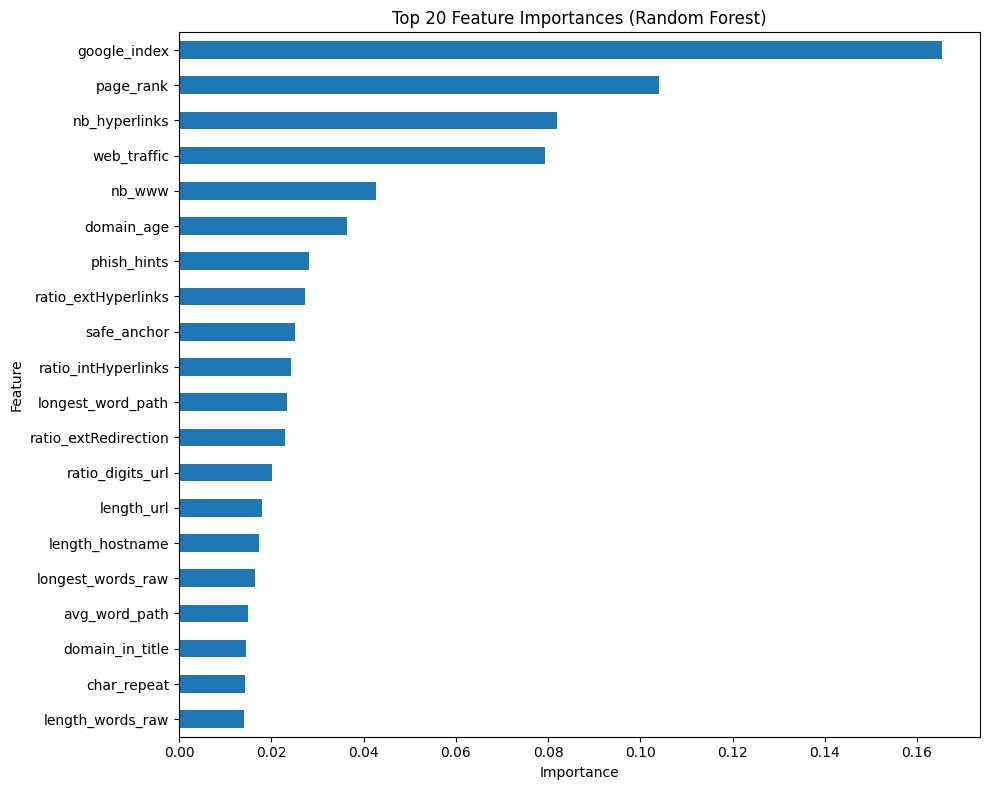

In [ ]:
# Get feature importances from the Random Forest model
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)

# Sort feature importances in descending order
sorted_feature_importances = feature_importances.sort_values(ascending=False)

# Plot the top N feature importances (you can adjust N)
top_n = 20  # Display top 20 features
plt.figure(figsize=(10, 8))
sorted_feature_importances[:top_n].plot(kind='barh')
plt.title(f'Top {top_n} Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Display the most important feature at the top
plt.tight_layout()
plt.show()

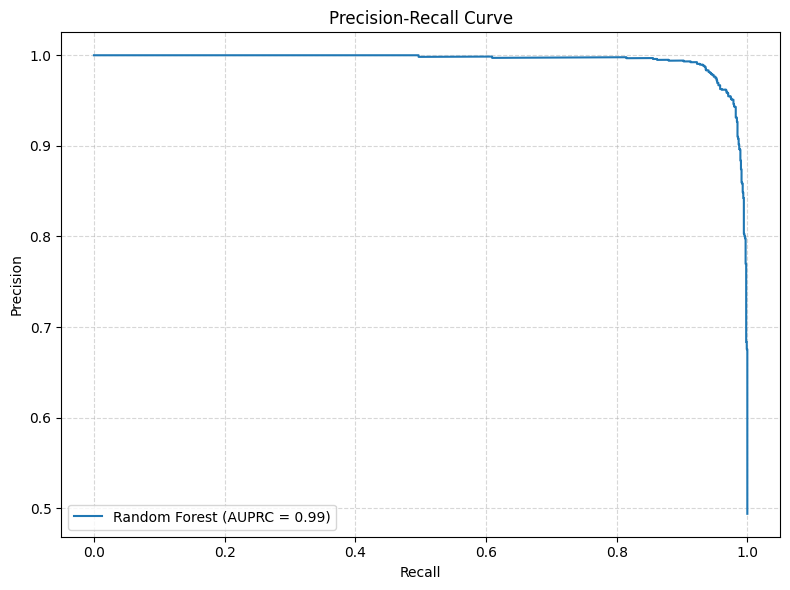

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

# Get precision and recall values for the Random Forest model
y_scores_rf = rf_model.predict_proba(X_test)[:, 1]  # Probability of the positive class
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_scores_rf)

# Calculate the Area Under the PR Curve (AUPRC)
auprc_rf = auc(recall_rf, precision_rf)

# Plot the PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUPRC = {auprc_rf:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

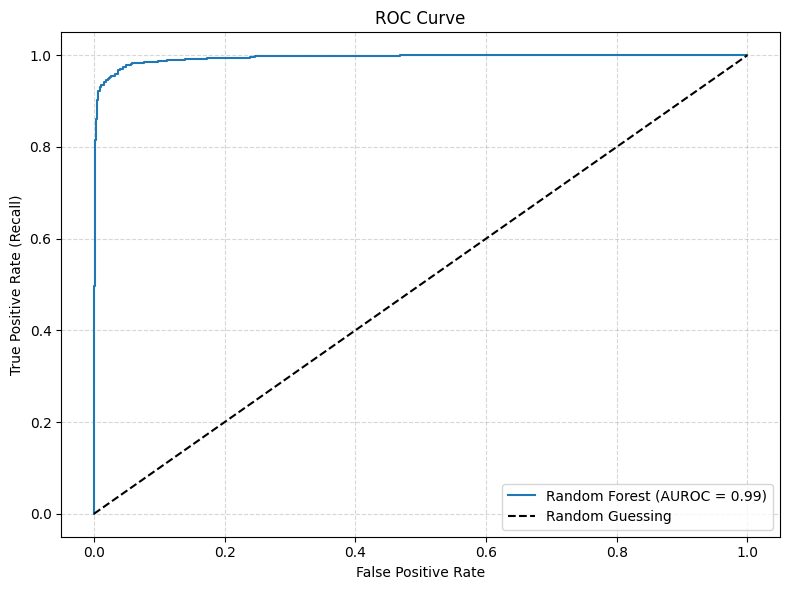

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_scores_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_scores_rf)

# Calculate Area Under the ROC Curve (AUROC)
auroc_rf = auc(fpr_rf, tpr_rf)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUROC = {auroc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()